# Clustering Analysis on Weld Database

## Workflow

Ce notebook utilise l'objet PCA sauvegardé depuis `preprocessing.ipynb` pour transformer les données directement :

1. **Chargement** : Charge les données originales depuis `processed_welddb.csv`
2. **Transformation PCA** : Utilise `pca_model.pkl` et `scaler_model.pkl` pour transformer les données
3. **Clustering** : Effectue le clustering sur les composantes PCA (11 composantes, 90% variance)
4. **Visualisation** : Utilise les 3 premières composantes PCA pour les graphiques 2D/3D

## Algorithmes de Clustering

- **K-Means** : Partitionnement classique basé sur les centroïdes
- **Mini-Batch K-Means** : Variante rapide de K-Means pour grands datasets
- **Hierarchical (Ward)** : Clustering hiérarchique agglomératif
- **DBSCAN** : Clustering basé sur la densité, détecte les outliers
- **KNN Analysis** : Analyse de densité et optimisation des paramètres

### Avantages :
- ✓ Pas de duplication : La PCA n'est calculée qu'une fois dans preprocessing
- ✓ Cohérence : Même transformation PCA sur toutes les données
- ✓ Réutilisable : Peut être appliqué sur de nouvelles données avec le même modèle PCA
- ✓ KNN pour validation : Analyse la structure et densité des clusters

### Prérequis :
Exécutez d'abord `preprocessing.ipynb` pour générer :
- `data/pca_model.pkl` - Objet PCA avec 11 composantes
- `data/scaler_model.pkl` - Objet StandardScaler
- `data/processed_welddb.csv` - Données preprocessées

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## Load and Prepare Data

## Load PCA Model 

In [2]:
import pickle
import os

# Load PCA and Scaler models if they exist
pca_model = None
scaler_model = None

if os.path.exists('data/pca_model.pkl'):
    with open('data/pca_model.pkl', 'rb') as f:
        pca_model = pickle.load(f)
    print("PCA model loaded successfully")
    print(f"  - Number of components: {pca_model.n_components_}")
    print(f"  - Total variance explained: {pca_model.explained_variance_ratio_.sum()*100:.2f}%")
    print(f"  - Variance by component: {[f'{v*100:.2f}%' for v in pca_model.explained_variance_ratio_]}")
else:
    print("PCA model not found. Make sure to run preprocessing.ipynb first.")

if os.path.exists('data/scaler_model.pkl'):
    with open('data/scaler_model.pkl', 'rb') as f:
        scaler_model = pickle.load(f)
    print("\nScaler model loaded successfully")
    print(f"  - Feature count: {len(scaler_model.feature_names_in_) if hasattr(scaler_model, 'feature_names_in_') else 'N/A'}")
else:
    print("\nScaler model not found.")

PCA model loaded successfully
  - Number of components: 11
  - Total variance explained: 88.19%
  - Variance by component: ['27.81%', '12.67%', '9.42%', '7.31%', '6.74%', '5.67%', '4.85%', '4.72%', '3.35%', '2.95%', '2.72%']

Scaler model loaded successfully
  - Feature count: 27


In [3]:
# Load preprocessed data
df = pd.read_csv('data/processed_welddb.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1652, 51)

Columns: ['carbon_wt_pct', 'silicon_wt_pct', 'manganese_wt_pct', 'sulphur_wt_pct', 'phosphorus_wt_pct', 'vanadium_wt_pct', 'oxygen_ppm', 'titanium_ppm', 'nitrogen_ppm', 'aluminium_ppm', 'current_a', 'voltage_v', 'heat_input_kj_per_mm', 'interpass_temp_c', 'pwht_temp_c', 'pwht_time_h', 'charpy_temp_c', 'charpy_toughness_j', 'weld_id', 'ac_dc_DC', 'electrode_polarity_-', 'electrode_polarity_0', 'weld_type_GMAA', 'weld_type_GTAA', 'weld_type_MMA', 'weld_type_NGGMA', 'weld_type_NGSAW', 'weld_type_SA', 'weld_type_SAA', 'weld_type_ShMA', 'weld_type_TSA', 'impurities_index', 'sulphur_phosphorus_ratio', 'power_input_kw', 'power_efficiency', 'current_density_proxy', 'hardenability_index', 'carbon_manganese_ratio', 'cooling_rate_proxy', 'thermal_cycle_intensity', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11']

First few rows:


,carbon_wt_pct,silicon_wt_pct,manganese_wt_pct,sulphur_wt_pct,phosphorus_wt_pct,vanadium_wt_pct,oxygen_ppm,titanium_ppm,nitrogen_ppm,aluminium_ppm,...,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,0.037,0.30,0.65,0.008,0.012,0.00037,431.8,40.0,86.6,2.5,...,-1.015361,1.320617,1.741492,0.485416,-0.389357,-1.461222,-0.921638,-0.358754,-1.448521,0.079215
1,0.037,0.30,0.65,0.008,0.012,0.00025,421.8,97.0,54.4,176.4,...,0.314386,0.354057,1.118307,1.403708,-2.582042,-1.497316,-0.103274,-0.929192,0.024905,-0.476580
2,0.037,0.30,0.65,0.008,0.012,0.00026,427.8,38.6,82.8,115.8,...,-1.032657,0.749094,0.692561,1.063390,-1.677046,-1.455234,-0.010820,-1.002029,0.284476,0.147369
3,0.037,0.31,1.03,0.007,0.014,0.03815,413.8,45.2,69.6,2.5,...,-0.365914,1.227649,0.149529,-0.041557,-0.481007,-1.546333,-0.390269,-0.247647,-1.394725,0.575667
4,0.037,0.31,1.03,0.007,0.014,0.00025,428.0,136.4,58.4,175.9,...,1.567864,0.551897,0.300714,0.882336,-2.258959,-1.590380,-0.456622,-0.654210,-0.328302,-0.294204


In [4]:
X_scaled = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11']]

## 1. K-Means Clustering

### Elbow Method to Find Optimal K

K=2: Inertia=29094.17, Silhouette=0.3564
K=3: Inertia=25101.98, Silhouette=0.3024
K=4: Inertia=22582.74, Silhouette=0.3121
K=5: Inertia=20698.08, Silhouette=0.1900
K=6: Inertia=18964.52, Silhouette=0.2064
K=7: Inertia=17909.28, Silhouette=0.2047
K=8: Inertia=16982.27, Silhouette=0.1785
K=9: Inertia=16045.98, Silhouette=0.1943
K=10: Inertia=15447.70, Silhouette=0.1935


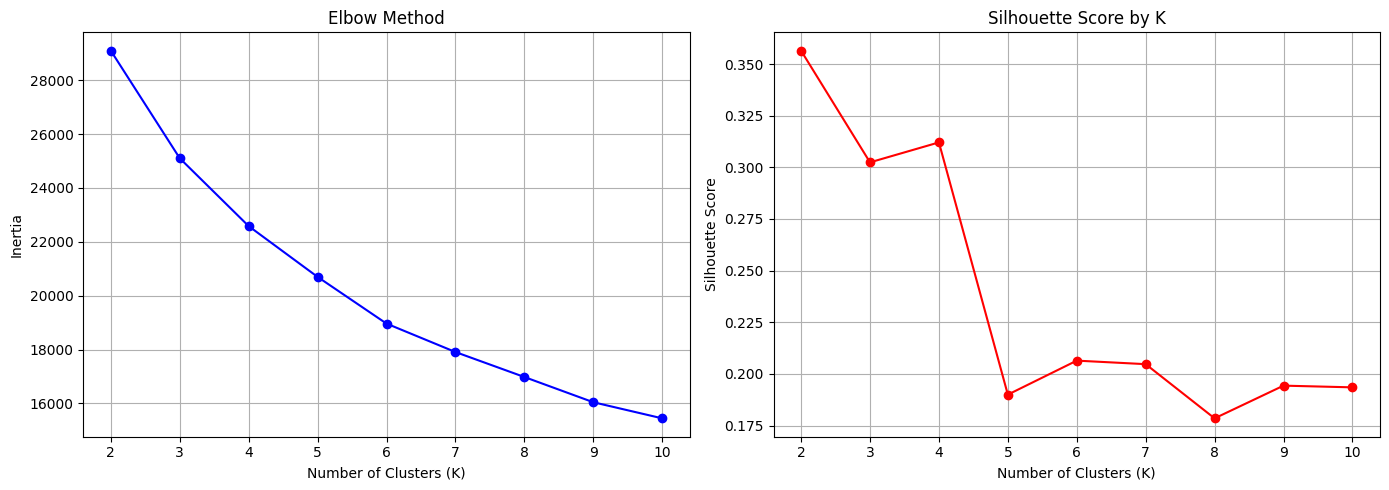

In [5]:
# Elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

# Silhouette score
axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score by K')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Apply K-Means with Optimal K

In [6]:
# Choose optimal K 
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['kmeans_cluster'] = kmeans_labels

print(f"K-Means with K={optimal_k}")
print(f"Silhouette Score: {silhouette_score(X_scaled, kmeans_labels):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, kmeans_labels):.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, kmeans_labels):.2f}")

print(f"\nCluster distribution:")
print(df['kmeans_cluster'].value_counts().sort_index())

K-Means with K=6
Silhouette Score: 0.2064
Davies-Bouldin Index: 1.5496
Calinski-Harabasz Score: 353.66

Cluster distribution:
kmeans_cluster
0    649
1    168
2    146
3    343
4    101
5    245
Name: count, dtype: int64


### Visualize K-Means Clusters

In [7]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)
pca_2d_variance = pca_2d.explained_variance_ratio_

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)
pca_3d_variance = pca_3d.explained_variance_ratio_


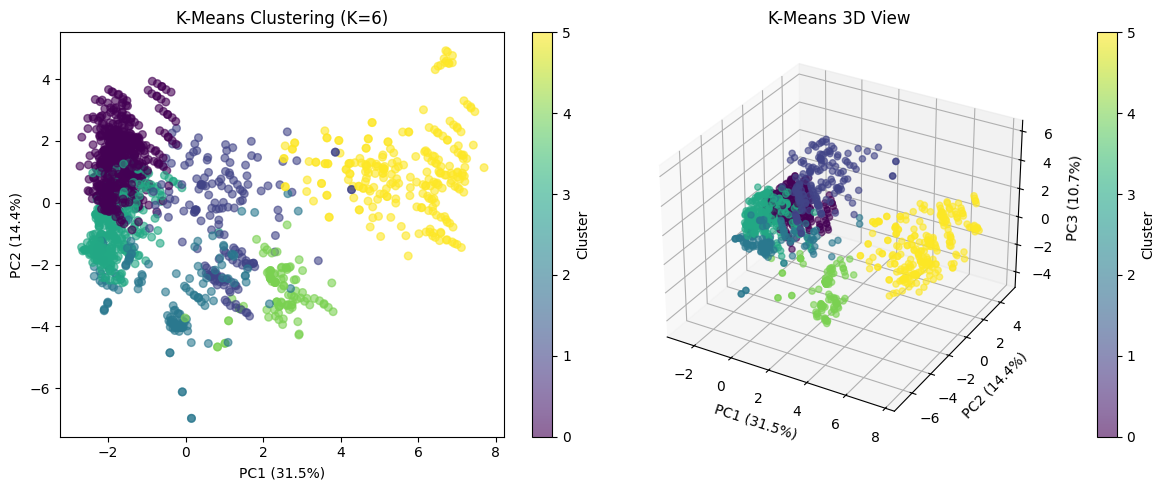

In [8]:
# 2D visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                      c=kmeans_labels, cmap='viridis', alpha=0.6, s=30)
if pca_2d_variance is not None:
    plt.xlabel(f'PC1 ({pca_2d_variance[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({pca_2d_variance[1]*100:.1f}%)')
else:
    plt.xlabel('PC1')
    plt.ylabel('PC2')
plt.title(f'K-Means Clustering (K={optimal_k})')
plt.colorbar(scatter, label='Cluster')

# 3D visualization
from mpl_toolkits.mplot3d import Axes3D

ax = plt.subplot(1, 2, 2, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=kmeans_labels, cmap='viridis', alpha=0.6, s=20)
if pca_3d_variance is not None:
    ax.set_xlabel(f'PC1 ({pca_3d_variance[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca_3d_variance[1]*100:.1f}%)')
    ax.set_zlabel(f'PC3 ({pca_3d_variance[2]*100:.1f}%)')
else:
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
ax.set_title(f'K-Means 3D View')
plt.colorbar(scatter, label='Cluster', ax=ax, pad=0.1)

plt.tight_layout()
plt.show()

## 2. Hierarchical Clustering

### Dendrogram

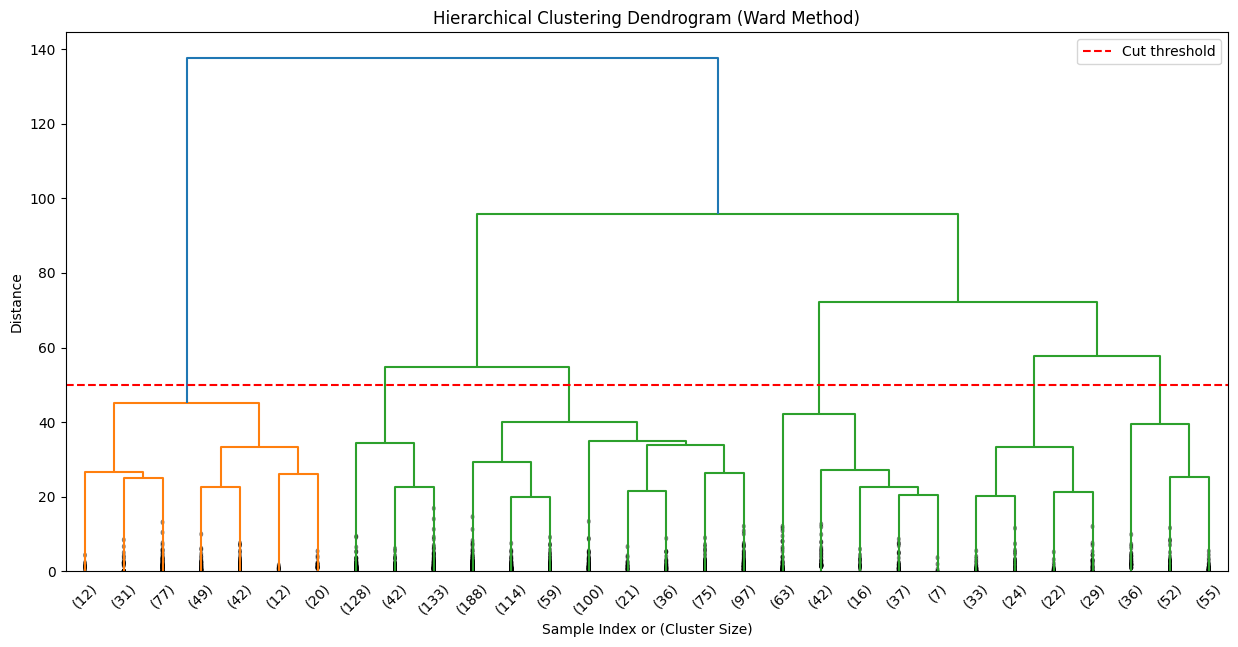

In [9]:
# Compute linkage
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, 
           truncate_mode='lastp',
           p=30,
           leaf_font_size=10,
           show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Ward Method)')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.axhline(y=50, color='r', linestyle='--', label='Cut threshold')
plt.legend()
plt.show()

### Apply Agglomerative Clustering

In [10]:
# Apply Agglomerative Clustering
n_clusters_hier = 6

hier_clustering = AgglomerativeClustering(n_clusters=n_clusters_hier, linkage='ward')
hier_labels = hier_clustering.fit_predict(X_scaled)

# Add to dataframe
df['hierarchical_cluster'] = hier_labels

print(f"Hierarchical Clustering with {n_clusters_hier} clusters")
print(f"Silhouette Score: {silhouette_score(X_scaled, hier_labels):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, hier_labels):.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, hier_labels):.2f}")

print(f"\nCluster distribution:")
print(df['hierarchical_cluster'].value_counts().sort_index())

Hierarchical Clustering with 6 clusters
Silhouette Score: 0.1835
Davies-Bouldin Index: 1.6254
Calinski-Harabasz Score: 334.92

Cluster distribution:
hierarchical_cluster
0    243
1    165
2    143
3    690
4    108
5    303
Name: count, dtype: int64


### Visualize Hierarchical Clusters

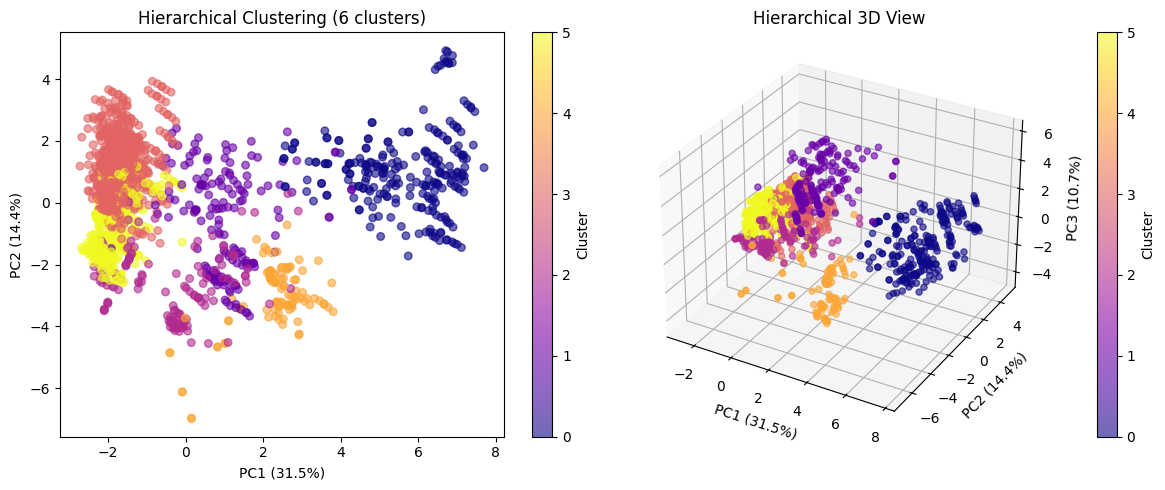

In [11]:
# 2D visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                      c=hier_labels, cmap='plasma', alpha=0.6, s=30)
if pca_2d_variance is not None:
    plt.xlabel(f'PC1 ({pca_2d_variance[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({pca_2d_variance[1]*100:.1f}%)')
else:
    plt.xlabel('PC1')
    plt.ylabel('PC2')
plt.title(f'Hierarchical Clustering ({n_clusters_hier} clusters)')
plt.colorbar(scatter, label='Cluster')

# 3D visualization
ax = plt.subplot(1, 2, 2, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=hier_labels, cmap='plasma', alpha=0.6, s=20)
if pca_3d_variance is not None:
    ax.set_xlabel(f'PC1 ({pca_3d_variance[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca_3d_variance[1]*100:.1f}%)')
    ax.set_zlabel(f'PC3 ({pca_3d_variance[2]*100:.1f}%)')
else:
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
ax.set_title(f'Hierarchical 3D View')
plt.colorbar(scatter, label='Cluster', ax=ax, pad=0.1)

plt.tight_layout()
plt.show()

## 3. DBSCAN Clustering

In [12]:
for eps in [0.5, 1, 2, 3, 4]:
    for min_samples in [5, 10, 20]:
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"eps={eps}, min_samples={min_samples} → {n_clusters} clusters")


eps=0.5, min_samples=5 → 14 clusters
eps=0.5, min_samples=10 → 1 clusters
eps=0.5, min_samples=20 → 0 clusters
eps=1, min_samples=5 → 48 clusters
eps=1, min_samples=10 → 16 clusters
eps=1, min_samples=20 → 4 clusters
eps=2, min_samples=5 → 47 clusters
eps=2, min_samples=10 → 19 clusters
eps=2, min_samples=20 → 5 clusters
eps=3, min_samples=5 → 17 clusters
eps=3, min_samples=10 → 10 clusters
eps=3, min_samples=20 → 7 clusters
eps=4, min_samples=5 → 3 clusters
eps=4, min_samples=10 → 2 clusters
eps=4, min_samples=20 → 1 clusters


In [13]:
# Apply DBSCAN
dbscan = DBSCAN(eps= 3, min_samples=20)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add to dataframe
df['dbscan_cluster'] = dbscan_labels

# Count clusters (excluding noise points labeled as -1)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN Clustering (eps=3, min_samples=10)")
print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.2f}%)")

if n_clusters_dbscan > 1:
    # Calculate metrics only for non-noise points
    mask = dbscan_labels != -1
    if mask.sum() > 0:
        print(f"Silhouette Score (excluding noise): {silhouette_score(X_scaled[mask], dbscan_labels[mask]):.4f}")

print(f"\nCluster distribution:")
print(pd.Series(dbscan_labels).value_counts().sort_index())

DBSCAN Clustering (eps=3, min_samples=10)
Number of clusters: 7
Number of noise points: 257 (15.56%)
Silhouette Score (excluding noise): 0.2691

Cluster distribution:
-1     257
 0    1085
 1      42
 2      80
 3     105
 4      25
 5      33
 6      25
Name: count, dtype: int64


### Visualize DBSCAN Clusters

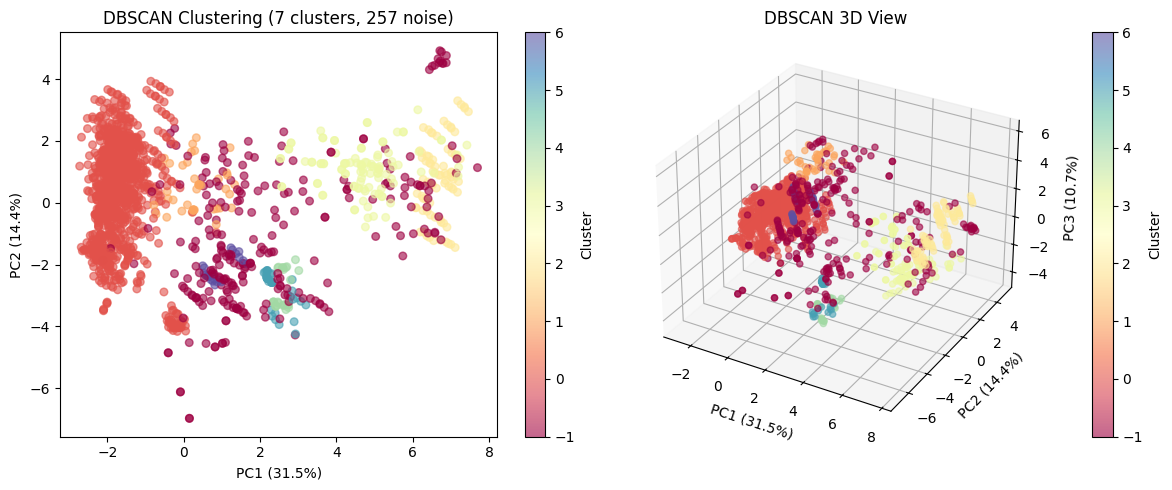

In [14]:
# 2D visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                      c=dbscan_labels, cmap='Spectral', alpha=0.6, s=30)
if pca_2d_variance is not None:
    plt.xlabel(f'PC1 ({pca_2d_variance[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({pca_2d_variance[1]*100:.1f}%)')
else:
    plt.xlabel('PC1')
    plt.ylabel('PC2')
plt.title(f'DBSCAN Clustering ({n_clusters_dbscan} clusters, {n_noise} noise)')
plt.colorbar(scatter, label='Cluster')

# 3D visualization
ax = plt.subplot(1, 2, 2, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=dbscan_labels, cmap='Spectral', alpha=0.6, s=20)
if pca_3d_variance is not None:
    ax.set_xlabel(f'PC1 ({pca_3d_variance[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca_3d_variance[1]*100:.1f}%)')
    ax.set_zlabel(f'PC3 ({pca_3d_variance[2]*100:.1f}%)')
else:
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
ax.set_title(f'DBSCAN 3D View')
plt.colorbar(scatter, label='Cluster', ax=ax, pad=0.1)

plt.tight_layout()
plt.show()

## 4. Mini-Batch K-Means Clustering

Mini-Batch K-Means is a faster variant of K-Means that uses mini-batches to reduce computation time while still attempting to optimize the same objective function.

In [15]:
# Apply Mini-Batch K-Means with same K as regular K-Means for comparison
import time

# Use the same optimal_k from K-Means
print(f"Applying Mini-Batch K-Means with K={optimal_k}")

# Measure time for regular K-Means
start_time = time.time()
kmeans_regular = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_regular.fit(X_scaled)
kmeans_time = time.time() - start_time

# Measure time for Mini-Batch K-Means
start_time = time.time()
minibatch_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, 
                                    batch_size=100, n_init=10)
minibatch_labels = minibatch_kmeans.fit_predict(X_scaled)
minibatch_time = time.time() - start_time

# Add to dataframe
df['minibatch_kmeans_cluster'] = minibatch_labels

print(f"\nPerformance Comparison:")
print(f"  Regular K-Means time: {kmeans_time:.4f}s")
print(f"  Mini-Batch K-Means time: {minibatch_time:.4f}s")
print(f"  Speedup: {kmeans_time/minibatch_time:.2f}x")

print(f"\nMini-Batch K-Means Metrics:")
print(f"Silhouette Score: {silhouette_score(X_scaled, minibatch_labels):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, minibatch_labels):.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, minibatch_labels):.2f}")

print(f"\nCluster distribution:")
print(df['minibatch_kmeans_cluster'].value_counts().sort_index())

Applying Mini-Batch K-Means with K=6

Performance Comparison:
  Regular K-Means time: 0.1910s
  Mini-Batch K-Means time: 0.0670s
  Speedup: 2.85x

Mini-Batch K-Means Metrics:
Silhouette Score: 0.1880
Davies-Bouldin Index: 1.6567
Calinski-Harabasz Score: 341.51

Cluster distribution:
minibatch_kmeans_cluster
0    595
1    245
2    181
3    100
4    430
5    101
Name: count, dtype: int64


### Visualize Mini-Batch K-Means Clusters

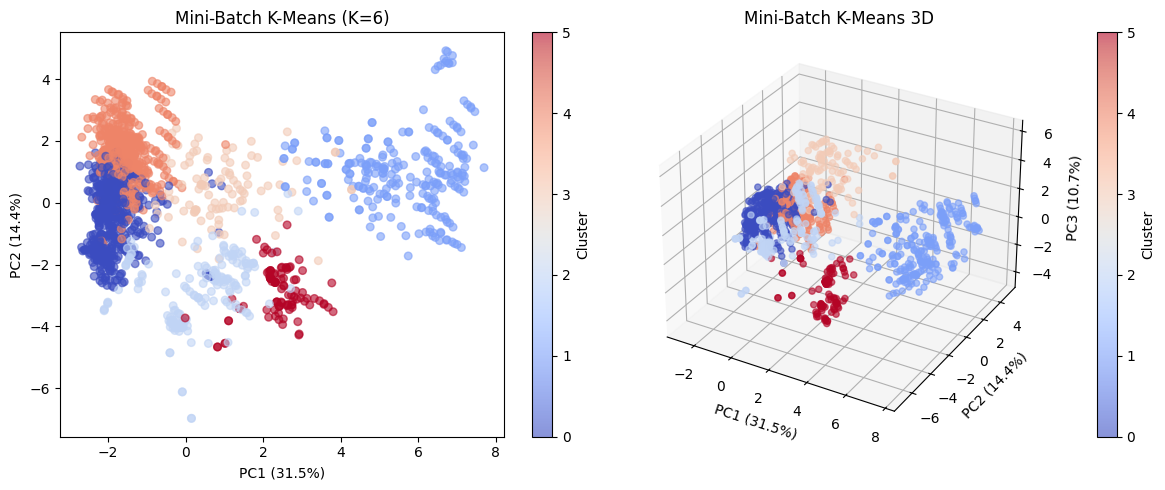

In [16]:
# 2D visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                      c=minibatch_labels, cmap='coolwarm', alpha=0.6, s=30)
if pca_2d_variance is not None:
    plt.xlabel(f'PC1 ({pca_2d_variance[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({pca_2d_variance[1]*100:.1f}%)')
else:
    plt.xlabel('PC1')
    plt.ylabel('PC2')
plt.title(f'Mini-Batch K-Means (K={optimal_k})')
plt.colorbar(scatter, label='Cluster')

# 3D visualization
ax = plt.subplot(1, 2, 2, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=minibatch_labels, cmap='coolwarm', alpha=0.6, s=20)
if pca_3d_variance is not None:
    ax.set_xlabel(f'PC1 ({pca_3d_variance[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca_3d_variance[1]*100:.1f}%)')
    ax.set_zlabel(f'PC3 ({pca_3d_variance[2]*100:.1f}%)')
else:
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
ax.set_title(f'Mini-Batch K-Means 3D')
plt.colorbar(scatter, label='Cluster', ax=ax, pad=0.1)

plt.tight_layout()
plt.show()

## 5. KNN-Based Cluster Analysis

KNN can be used to analyze cluster quality by examining the neighborhood structure. We'll use it to:
1. Find optimal epsilon for DBSCAN
2. Detect cluster boundaries and overlap
3. Measure cluster density

### K-Distance Graph for Optimal Eps (DBSCAN)

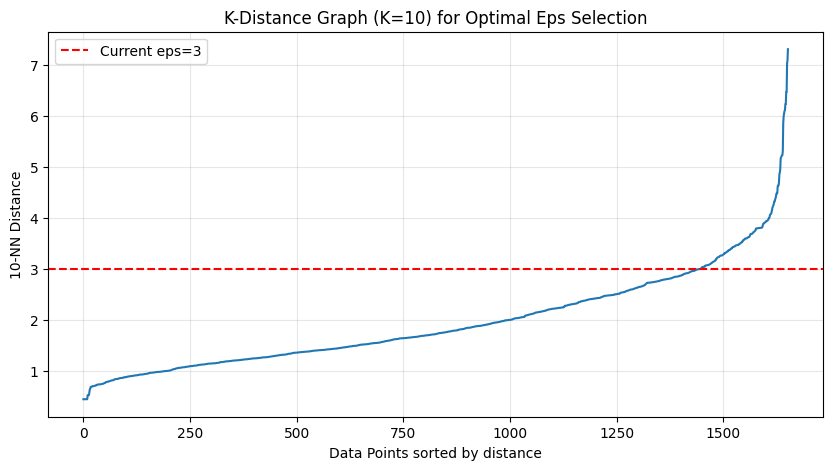


Suggested optimal eps (based on elbow): 6.46


In [17]:
# Use KNN to find optimal eps for DBSCAN
# The idea: plot k-distances to find the "elbow" point

k = 10  # typically use min_samples for DBSCAN
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances
distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.ylabel(f'{k}-NN Distance')
plt.xlabel('Data Points sorted by distance')
plt.title(f'K-Distance Graph (K={k}) for Optimal Eps Selection')
plt.axhline(y=3, color='r', linestyle='--', label='Current eps=3')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Suggest optimal eps (elbow point)
# Simple heuristic: find point of maximum curvature
second_derivative = np.diff(distances, 2)
if len(second_derivative) > 0:
    elbow_idx = np.argmax(second_derivative)
    suggested_eps = distances[elbow_idx]
    print(f"\nSuggested optimal eps (based on elbow): {suggested_eps:.2f}")
else:
    print("\nCould not determine optimal eps")

### Cluster Density Analysis with KNN

CLUSTER DENSITY ANALYSIS (using KNN)

Average KNN distance by K-Means cluster:
(Lower distance = Higher density)

                  mean     std     min     max
kmeans_cluster                                
0               0.7653  0.3121  0.2358  2.0109
1               1.3246  0.7806  0.1054  3.5228
2               0.9152  0.6309  0.2621  2.7184
3               0.7545  0.3616  0.2321  2.7404
4               0.8711  0.6947  0.0000  3.2910
5               1.0573  0.3694  0.3267  2.5666


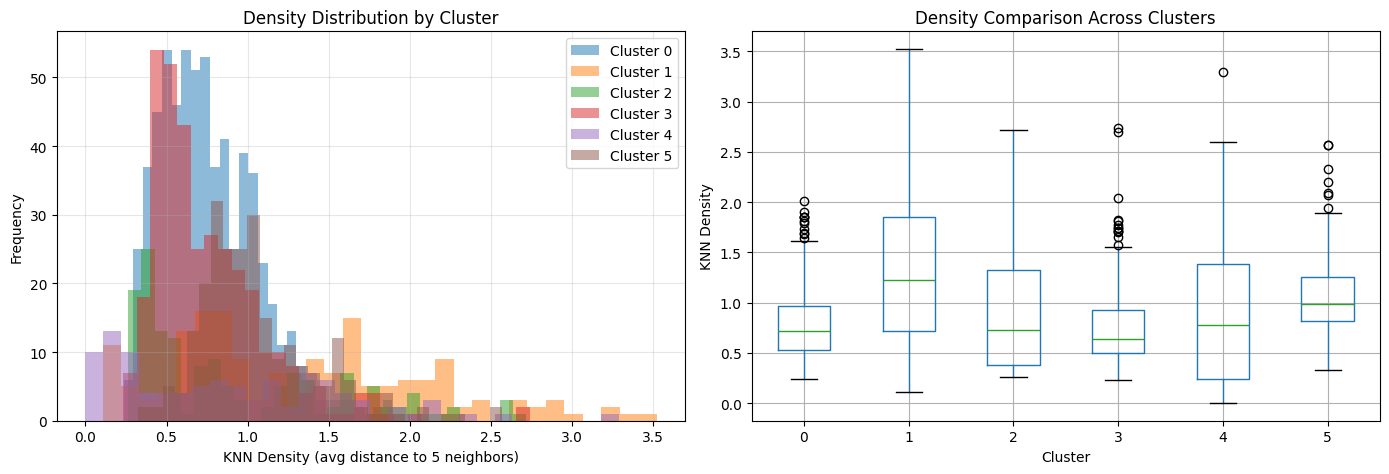


✓ Clusters with lower KNN distance are more compact/dense
✓ Higher variance indicates more heterogeneous clusters


In [18]:
# Analyze density of each cluster using K-Means clusters
k_neighbors = 5
neighbors_density = NearestNeighbors(n_neighbors=k_neighbors)
neighbors_density.fit(X_scaled)
distances_all, _ = neighbors_density.kneighbors(X_scaled)

# Calculate average distance to k nearest neighbors for each point
avg_distances = distances_all.mean(axis=1)

# Add to dataframe
df['knn_density'] = avg_distances

# Analyze density by cluster
print("="*70)
print("CLUSTER DENSITY ANALYSIS (using KNN)")
print("="*70)
print("\nAverage KNN distance by K-Means cluster:")
print("(Lower distance = Higher density)")
print()

cluster_density = df.groupby('kmeans_cluster')['knn_density'].agg(['mean', 'std', 'min', 'max'])
print(cluster_density.round(4))

# Visualize density distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for cluster in sorted(df['kmeans_cluster'].unique()):
    cluster_data = df[df['kmeans_cluster'] == cluster]['knn_density']
    plt.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster}', bins=30)
plt.xlabel('KNN Density (avg distance to 5 neighbors)')
plt.ylabel('Frequency')
plt.title('Density Distribution by Cluster')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
df.boxplot(column='knn_density', by='kmeans_cluster', ax=plt.gca())
plt.xlabel('Cluster')
plt.ylabel('KNN Density')
plt.title('Density Comparison Across Clusters')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

print(f"\n✓ Clusters with lower KNN distance are more compact/dense")
print(f"✓ Higher variance indicates more heterogeneous clusters")

## 6. Spectral Clustering (KNN-based)

Spectral Clustering uses the spectrum (eigenvalues) of the similarity matrix to perform dimensionality reduction before clustering in fewer dimensions. It constructs a k-NN graph internally.

In [19]:
# Apply Spectral Clustering
n_clusters_spectral = optimal_k  # Use same K as K-Means for fair comparison

print(f"Applying Spectral Clustering with K={n_clusters_spectral}")
print("This method constructs a k-NN graph and uses spectral decomposition")

spectral = SpectralClustering(
    n_clusters=n_clusters_spectral,
    affinity='nearest_neighbors',  # Use KNN graph
    n_neighbors=10,  # Number of neighbors for KNN graph
    assign_labels='kmeans',  # Use K-Means for final assignment
    random_state=42
)

spectral_labels = spectral.fit_predict(X_scaled)

# Add to dataframe
df['spectral_cluster'] = spectral_labels

print(f"\nSpectral Clustering Metrics:")
print(f"Silhouette Score: {silhouette_score(X_scaled, spectral_labels):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, spectral_labels):.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, spectral_labels):.2f}")

print(f"\nCluster distribution:")
print(df['spectral_cluster'].value_counts().sort_index())

Applying Spectral Clustering with K=6
This method constructs a k-NN graph and uses spectral decomposition

Spectral Clustering Metrics:
Silhouette Score: 0.2363
Davies-Bouldin Index: 1.5155
Calinski-Harabasz Score: 171.89

Cluster distribution:
spectral_cluster
0    998
1    485
2    111
3     10
4     36
5     12
Name: count, dtype: int64


### Visualize Spectral Clusters

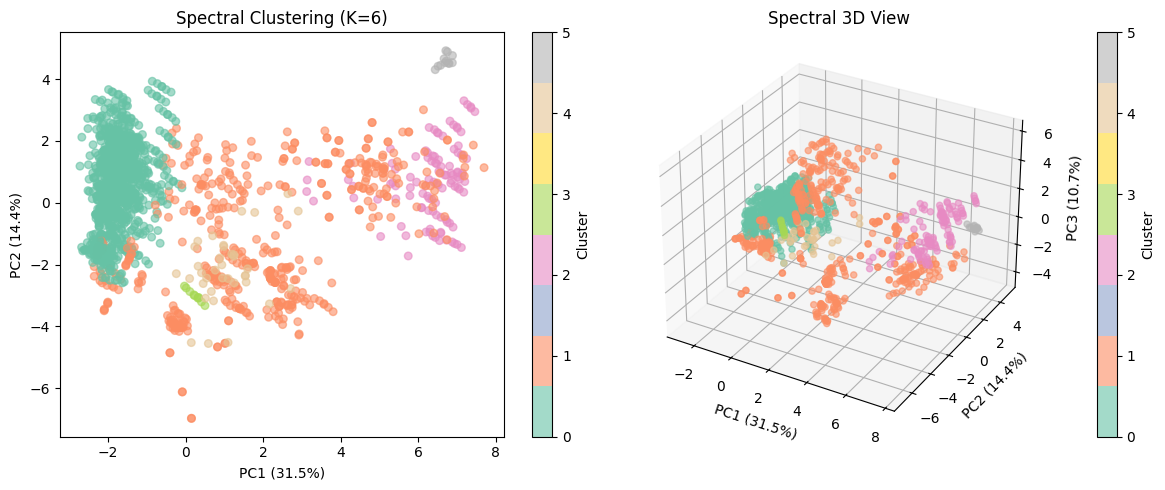

In [20]:
# 2D visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                      c=spectral_labels, cmap='Set2', alpha=0.6, s=30)
if pca_2d_variance is not None:
    plt.xlabel(f'PC1 ({pca_2d_variance[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({pca_2d_variance[1]*100:.1f}%)')
else:
    plt.xlabel('PC1')
    plt.ylabel('PC2')
plt.title(f'Spectral Clustering (K={n_clusters_spectral})')
plt.colorbar(scatter, label='Cluster')

# 3D visualization
ax = plt.subplot(1, 2, 2, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=spectral_labels, cmap='Set2', alpha=0.6, s=20)
if pca_3d_variance is not None:
    ax.set_xlabel(f'PC1 ({pca_3d_variance[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca_3d_variance[1]*100:.1f}%)')
    ax.set_zlabel(f'PC3 ({pca_3d_variance[2]*100:.1f}%)')
else:
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
ax.set_title(f'Spectral 3D View')
plt.colorbar(scatter, label='Cluster', ax=ax, pad=0.1)

plt.tight_layout()
plt.show()

In [21]:
# Compare all clustering methods
comparison_results = []

# K-Means
comparison_results.append({
    'Method': 'K-Means',
    'N_Clusters': optimal_k,
    'Silhouette': silhouette_score(X_scaled, kmeans_labels),
    'Davies-Bouldin': davies_bouldin_score(X_scaled, kmeans_labels),
    'Calinski-Harabasz': calinski_harabasz_score(X_scaled, kmeans_labels)
})

# Mini-Batch K-Means
comparison_results.append({
    'Method': 'Mini-Batch K-Means',
    'N_Clusters': optimal_k,
    'Silhouette': silhouette_score(X_scaled, minibatch_labels),
    'Davies-Bouldin': davies_bouldin_score(X_scaled, minibatch_labels),
    'Calinski-Harabasz': calinski_harabasz_score(X_scaled, minibatch_labels)
})

# Hierarchical
comparison_results.append({
    'Method': 'Hierarchical',
    'N_Clusters': n_clusters_hier,
    'Silhouette': silhouette_score(X_scaled, hier_labels),
    'Davies-Bouldin': davies_bouldin_score(X_scaled, hier_labels),
    'Calinski-Harabasz': calinski_harabasz_score(X_scaled, hier_labels)
})

# Spectral
comparison_results.append({
    'Method': 'Spectral (KNN)',
    'N_Clusters': n_clusters_spectral,
    'Silhouette': silhouette_score(X_scaled, spectral_labels),
    'Davies-Bouldin': davies_bouldin_score(X_scaled, spectral_labels),
    'Calinski-Harabasz': calinski_harabasz_score(X_scaled, spectral_labels)
})

# DBSCAN (only if valid clusters exist)
if n_clusters_dbscan > 1:
    mask = dbscan_labels != -1
    if mask.sum() > 0:
        comparison_results.append({
            'Method': 'DBSCAN',
            'N_Clusters': n_clusters_dbscan,
            'Silhouette': silhouette_score(X_scaled[mask], dbscan_labels[mask]),
            'Davies-Bouldin': davies_bouldin_score(X_scaled[mask], dbscan_labels[mask]),
            'Calinski-Harabasz': calinski_harabasz_score(X_scaled[mask], dbscan_labels[mask])
        })

comparison_df = pd.DataFrame(comparison_results)
print("\nClustering Methods Comparison:")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)
print("\nNotes:")
print("- Higher Silhouette Score is better (range: -1 to 1)")
print("- Lower Davies-Bouldin Index is better")
print("- Higher Calinski-Harabasz Score is better")


Clustering Methods Comparison:
            Method  N_Clusters  Silhouette  Davies-Bouldin  Calinski-Harabasz
           K-Means           6    0.206424        1.549557         353.658297
Mini-Batch K-Means           6    0.187967        1.656669         341.509673
      Hierarchical           6    0.183518        1.625361         334.921243
    Spectral (KNN)           6    0.236261        1.515480         171.893350
            DBSCAN           7    0.269064        1.036139         211.092764

Notes:
- Higher Silhouette Score is better (range: -1 to 1)
- Lower Davies-Bouldin Index is better
- Higher Calinski-Harabasz Score is better


In [22]:
# Multi-criteria scoring system for model selection
print("\n" + "="*90)
print("BEST MODEL SELECTION (Multi-Criteria Scoring)")
print("="*90)

# Create copy for scoring (exclude DBSCAN for now as it may have different K)
scoring_df = comparison_df[comparison_df['N_Clusters'] == optimal_k].copy()

# Normalize metrics to [0, 1] range
# Silhouette: already in [-1, 1], map to [0, 1]
scoring_df['Silhouette_norm'] = (scoring_df['Silhouette'] + 1) / 2

# Davies-Bouldin: lower is better, invert it
# Normalize to [0, 1] where 1 is best
db_min = scoring_df['Davies-Bouldin'].min()
db_max = scoring_df['Davies-Bouldin'].max()
scoring_df['DaviesBouldin_norm'] = 1 - (scoring_df['Davies-Bouldin'] - db_min) / (db_max - db_min + 1e-10)

# Calinski-Harabasz: higher is better
# Normalize to [0, 1] where 1 is best
ch_min = scoring_df['Calinski-Harabasz'].min()
ch_max = scoring_df['Calinski-Harabasz'].max()
scoring_df['CalinskiHarabasz_norm'] = (scoring_df['Calinski-Harabasz'] - ch_min) / (ch_max - ch_min + 1e-10)

# Composite score (weighted average)
weight_silhouette = 0.40
weight_davies = 0.30
weight_calinski = 0.30

scoring_df['Composite_Score'] = (
    weight_silhouette * scoring_df['Silhouette_norm'] +
    weight_davies * scoring_df['DaviesBouldin_norm'] +
    weight_calinski * scoring_df['CalinskiHarabasz_norm']
)

# Sort by composite score
scoring_df_sorted = scoring_df.sort_values('Composite_Score', ascending=False)

print("\nWeighting:")
print(f"  - Silhouette Score: {weight_silhouette*100:.0f}% (cluster separation)")
print(f"  - Davies-Bouldin:   {weight_davies*100:.0f}% (cluster compactness)")
print(f"  - Calinski-Harabasz: {weight_calinski*100:.0f}% (variance ratio)")

print("\nRanking (Composite Score):")
print(scoring_df_sorted[['Method', 'Silhouette', 'Davies-Bouldin', 
                          'Calinski-Harabasz', 'Composite_Score']].to_string(index=False))

# Select best model
best_method = scoring_df_sorted.iloc[0]['Method']
best_score = scoring_df_sorted.iloc[0]['Composite_Score']

print("\n" + "="*90)
print(f"🏆 BEST MODEL: {best_method}")
print(f"   Composite Score: {best_score:.4f}")
print("="*90)

# Map method name to labels
method_to_labels = {
    'K-Means': kmeans_labels,
    'Mini-Batch K-Means': minibatch_labels,
    'Hierarchical': hier_labels,
    'Spectral (KNN)': spectral_labels
}

best_labels = method_to_labels[best_method]
df['best_cluster'] = best_labels

print(f"\nBest clustering labels saved in 'best_cluster' column")
print(f"Distribution:")
print(pd.Series(best_labels).value_counts().sort_index())


BEST MODEL SELECTION (Multi-Criteria Scoring)

Weighting:
  - Silhouette Score: 40% (cluster separation)
  - Davies-Bouldin:   30% (cluster compactness)
  - Calinski-Harabasz: 30% (variance ratio)

Ranking (Composite Score):
            Method  Silhouette  Davies-Bouldin  Calinski-Harabasz  Composite_Score
           K-Means    0.206424        1.549557         353.658297         0.768879
      Hierarchical    0.183518        1.625361         334.921243         0.572303
    Spectral (KNN)    0.236261        1.515480         171.893350         0.547252
Mini-Batch K-Means    0.187967        1.656669         341.509673         0.517542

🏆 BEST MODEL: K-Means
   Composite Score: 0.7689

Best clustering labels saved in 'best_cluster' column
Distribution:
0    649
1    168
2    146
3    343
4    101
5    245
Name: count, dtype: int64


## 7. Model Comparison and Best Model Selection

### Cluster Comparisons and Distances

CLUSTER SIMILARITY ANALYSIS

Pairwise Euclidean Distances between Cluster Centroids:
(Lower distance = More similar clusters)

           Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5
Cluster 0      0.000      4.915      5.231      2.901      6.514      7.352
Cluster 1      4.915      0.000      5.225      4.744      6.508      6.280
Cluster 2      5.231      5.225      0.000      4.828      5.412      7.869
Cluster 3      2.901      4.744      4.828      0.000      5.719      7.775
Cluster 4      6.514      6.508      5.412      5.719      0.000      5.844
Cluster 5      7.352      6.280      7.869      7.775      5.844      0.000

Cluster Pairs (excluding self):
  Cluster 0 ↔ Cluster 1: distance = 4.915
  Cluster 0 ↔ Cluster 2: distance = 5.231
  Cluster 0 ↔ Cluster 3: distance = 2.901
  Cluster 0 ↔ Cluster 4: distance = 6.514
  Cluster 0 ↔ Cluster 5: distance = 7.352
  Cluster 1 ↔ Cluster 2: distance = 5.225
  Cluster 1 ↔ Cluster 3: distance = 4.744
  Cluster 1 ↔ 

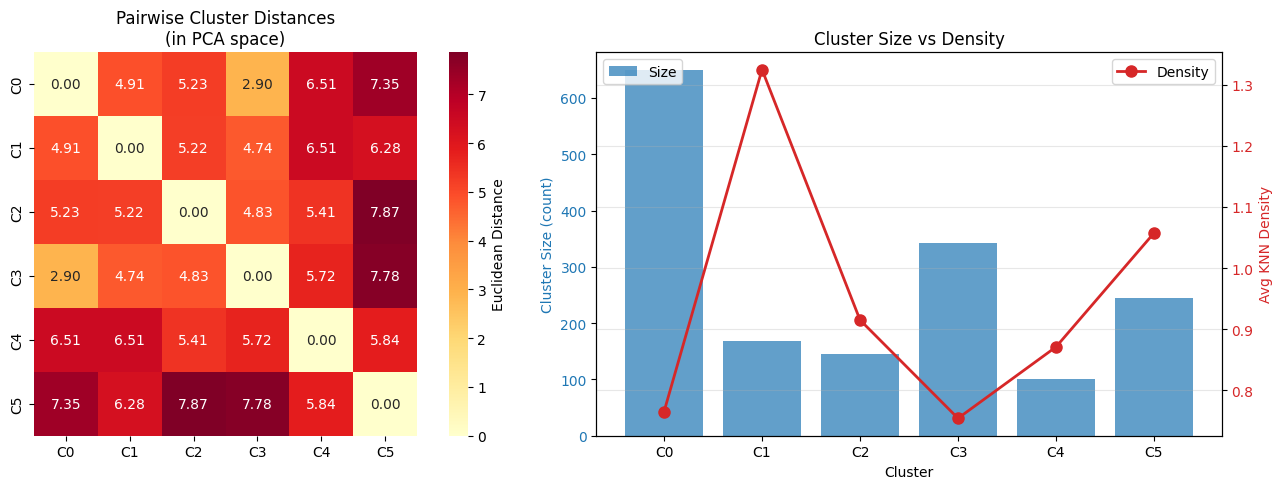

In [28]:
# Calculate centroids in PCA space
centroids_pca = np.array([X_scaled[best_labels == i].mean(axis=0) for i in range(optimal_k)])

# Calculate pairwise distances between centroids
from scipy.spatial.distance import pdist, squareform
centroid_distances = squareform(pdist(centroids_pca, metric='euclidean'))

print("="*90)
print("CLUSTER SIMILARITY ANALYSIS")
print("="*90)

print("\nPairwise Euclidean Distances between Cluster Centroids:")
print("(Lower distance = More similar clusters)")
print()

distance_df = pd.DataFrame(centroid_distances, 
                           index=[f'Cluster {i}' for i in range(optimal_k)],
                           columns=[f'Cluster {i}' for i in range(optimal_k)])
print(distance_df.round(3).to_string())

# Find most similar and most different pairs
print("\nCluster Pairs (excluding self):")
for i in range(optimal_k):
    for j in range(i+1, optimal_k):
        dist = centroid_distances[i, j]
        print(f"  Cluster {i} ↔ Cluster {j}: distance = {dist:.3f}")

# Identify most similar and most different
triu_indices = np.triu_indices(optimal_k, k=1)
triu_distances = centroid_distances[triu_indices]
min_idx = np.argmin(triu_distances)
max_idx = np.argmax(triu_distances)

most_similar = (triu_indices[0][min_idx], triu_indices[1][min_idx])
most_different = (triu_indices[0][max_idx], triu_indices[1][max_idx])

print(f"\n→ Most SIMILAR clusters: {most_similar[0]} and {most_similar[1]} (distance: {triu_distances[min_idx]:.3f})")
print(f"→ Most DIFFERENT clusters: {most_different[0]} and {most_different[1]} (distance: {triu_distances[max_idx]:.3f})")
# Count points per cluster
cluster_counts = df['best_cluster'].value_counts().sort_index()

# Visualize distance matrix
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap(centroid_distances, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=[f'C{i}' for i in range(optimal_k)],
            yticklabels=[f'C{i}' for i in range(optimal_k)],
            square=True, cbar_kws={'label': 'Euclidean Distance'})
plt.title('Pairwise Cluster Distances\n(in PCA space)')

# Plot 2: Cluster sizes with density
plt.subplot(1, 2, 2)
x_pos = np.arange(optimal_k)
sizes = cluster_counts.values
densities = df.groupby('best_cluster')['knn_density'].mean().values

fig2_ax1 = plt.gca()
color = 'tab:blue'
fig2_ax1.set_xlabel('Cluster')
fig2_ax1.set_ylabel('Cluster Size (count)', color=color)
bars = fig2_ax1.bar(x_pos, sizes, alpha=0.7, color=color, label='Size')
fig2_ax1.tick_params(axis='y', labelcolor=color)
fig2_ax1.set_xticks(x_pos)
fig2_ax1.set_xticklabels([f'C{i}' for i in range(optimal_k)])

# Add density on secondary axis
fig2_ax2 = fig2_ax1.twinx()
color = 'tab:red'
fig2_ax2.set_ylabel('Avg KNN Density', color=color)
line = fig2_ax2.plot(x_pos, densities, 'o-', color=color, linewidth=2, markersize=8, label='Density')
fig2_ax2.tick_params(axis='y', labelcolor=color)

plt.title('Cluster Size vs Density')
fig2_ax1.legend(loc='upper left')
fig2_ax2.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Generate Interpretation Report

In [33]:
# Save clustered data
df.to_csv('data/clustered_welddb.csv', index=False)
print("Clustered data saved to 'data/clustered_welddb.csv'")

# Save comparison results
comparison_df.to_csv('data/clustering_comparison.csv', index=False)
print("Clustering comparison saved to 'data/clustering_comparison.csv'")

print(f"\nDataframe now contains {len(df)} rows with cluster labels:")
print(f"- kmeans_cluster")
print(f"- minibatch_kmeans_cluster")
print(f"- hierarchical_cluster")
print(f"- spectral_cluster")
print(f"- dbscan_cluster")
print(f"- best_cluster (from {best_method})")
print(f"- knn_density (cluster density metric)")

print(f"\nTotal columns in saved file: {len(df.columns)}")
print(f"\n✓ All results saved successfully!")

Clustered data saved to 'data/clustered_welddb.csv'
Clustering comparison saved to 'data/clustering_comparison.csv'

Dataframe now contains 1652 rows with cluster labels:
- kmeans_cluster
- minibatch_kmeans_cluster
- hierarchical_cluster
- spectral_cluster
- dbscan_cluster
- best_cluster (from K-Means)
- knn_density (cluster density metric)

Total columns in saved file: 58

✓ All results saved successfully!
